In [105]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import interpolate
import os

In [149]:
ABI_file = nc.Dataset('/localdata/cases/20190403/ABI/ACHAC/OR_ABI-L2-ACHAC-M6_G16_s20190932001196_e20190932003568_c20190932005207.nc','r')
GLM_file = nc.Dataset('/localdata/cases/20190403/GLM_grids/2019/Apr/04/GLM-00-00_20190404_001700_60_1src_056urad-dx_total_energy.nc','r')

In [164]:
ABI_x = ABI_file.variables['x'][:] 
ABI_y = ABI_file.variables['y'][:]
ABI_var = ABI_file.variables['HT'][:,:]
GLM_x = GLM_file.variables['x'][:]
GLM_y = GLM_file.variables['y'][:]
GLM_var = np.squeeze(GLM_file.variables['total_energy'][:,:])
ABI_var = np.ma.filled(ABI_var,fill_value=0)
print (GLM_var.shape)
print (ABI_var.shape)

(2499, 1499)
(300, 500)


In [165]:
f = interpolate.interp2d(ABI_y,ABI_x,ABI_var.T, kind='linear')
ABI_new = f(GLM_y,GLM_x) #Converting TO the GLM coordinates
TF = GLM_var>0
ABI_cut = TF*ABI_new

ABI_stack = np.dstack((ABI_cut))
print (ABI_new.shape)
print (GLM_x.shape)

(2499, 1499)
(2499,)


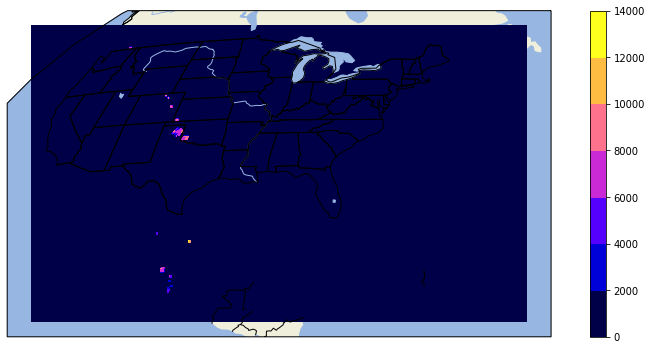

In [171]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.Geostationary(-75, 35786023.0))

plt.contourf(GLM_x*35786023.0,GLM_y*35786023.0,ABI_cut.T,cmap=plt.get_cmap('gnuplot2'))
#ax.set_extent([-102.24, -96.80, 34.10, 36.40])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.STATES, zorder=8)
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

ax = plt.colorbar()
#plt.savefig('../Downloads/thing1.pdf')
plt.show()

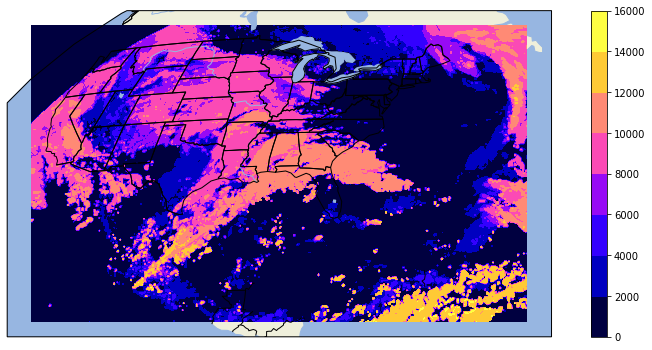

In [170]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.Geostationary(-75, 35786023.0))

plt.contourf(ABI_x*35786023.0,ABI_y*35786023.0,ABI_var,cmap=plt.get_cmap('gnuplot2'))
#ax.set_extent([-102.24, -96.80, 34.10, 36.40])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.STATES, zorder=8)
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

ax = plt.colorbar()
#plt.savefig('../Downloads/thing2.pdf')
plt.show()

In [26]:
ABI_file

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v35, 20 July 2016)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 2km at nadir
    orbital_slot: GOES-East
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: CONUS
    instrument_ID: FM1
    dataset_name: OR_ABI-L2-CODC-M6_G16_s20190932041196_e20190932043569_c20190932045271.nc
    iso_series_metadata_id: 49b3d350-afec-11e1-afa6-0800200c9a66
    title: ABI L2 Cloud Optical Depth at 640 nm
    summary: The Cloud Optical Depth product consists of pixels containing t

In [35]:
GLM_file

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): nx(2499), ny(1499), ntimes(1)
    variables(dimensions): int32 goes_imager_projection(), float32 x(nx), float32 y(ny), float32 time(ntimes), float32 total_energy(ntimes,nx,ny)
    groups: 

1. Read in each file on a minute by minute basis
2. Linearlly interpolate ABI grid to match GLM grid
3. Use true/false array from the GLM values to retain on the needed ABI data points